<a href="https://colab.research.google.com/github/knc6/jarvis-tools-notebooks/blob/master/jarvis-tools-notebooks/BandOffSet_QE_InterMat.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Band offset calcularions with InterMat+QuantumEspresso
(Note: for computational cost reasons, in this demo we use less k-points)



In [1]:
%%time
import os
os.chdir('/content')
# Clone the QE git
if not os.path.exists('q-e'):
   os.system('git clone https://github.com/QEF/q-e.git')
# Install the dependencies
!apt-get install -y libfftw3-3 libfftw3-dev libfftw3-doc
os.chdir('q-e')
# run the configure file
#!DFLAGS='-D__OPENMP -D__FFTW3 -D__MPI -D__SCALAPACK' FFT_LIBS='-lfftw3'  ./configure --enable-openmp

!!DFLAGS='-D__FFTW3 ' FFT_LIBS='-lfftw3'  ./configure
! make pw

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libfftw3-bin libfftw3-double3 libfftw3-long3 libfftw3-quad3 libfftw3-single3
The following NEW packages will be installed:
  libfftw3-3 libfftw3-bin libfftw3-dev libfftw3-doc libfftw3-double3 libfftw3-long3 libfftw3-quad3
  libfftw3-single3
0 upgraded, 8 newly installed, 0 to remove and 49 not upgraded.
Need to get 4,918 kB of archives.
After this operation, 26.2 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 libfftw3-double3 amd64 3.3.8-2ubuntu8 [770 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/main amd64 libfftw3-long3 amd64 3.3.8-2ubuntu8 [335 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/main amd64 libfftw3-single3 amd64 3.3.8-2ubuntu8 [800 kB]
Get:4 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libfftw3-3 amd64 3.3.8-2ubuntu8 [1,756 B]
Get:5 http://archive.ubuntu.com

In [2]:
!make pp

test -d bin || mkdir bin
( cd UtilXlib ; make TLDEPS= all || exit 1 )
make[1]: Entering directory '/content/q-e/UtilXlib'
make[1]: Nothing to be done for 'all'.
make[1]: Leaving directory '/content/q-e/UtilXlib'
cd install ; make -f extlibs_makefile libcuda
make[1]: Entering directory '/content/q-e/install'
make[1]: Nothing to be done for 'libcuda'.
make[1]: Leaving directory '/content/q-e/install'
( cd LAXlib ; make TLDEPS= all || exit 1 )
make[1]: Entering directory '/content/q-e/LAXlib'
make[1]: Nothing to be done for 'all'.
make[1]: Leaving directory '/content/q-e/LAXlib'
( cd FFTXlib ; make TLDEPS= all || exit 1 )
make[1]: Entering directory '/content/q-e/FFTXlib'
( cd src ; make all || exit 1 )
make[2]: Entering directory '/content/q-e/FFTXlib/src'
make[2]: Nothing to be done for 'all'.
make[2]: Leaving directory '/content/q-e/FFTXlib/src'
make[1]: Leaving directory '/content/q-e/FFTXlib'
( cd upflib ; make TLDEPS= all || exit 1 )
make[1]: Entering directory '/content/q-e/upflib'

In [3]:
!pip install -qqq intermat spglib ase

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 23.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 53.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 58.6 MB/s eta 0:00:00


In [4]:
import os
os.chdir('/content')

In [6]:
from jarvis.core.atoms import Atoms
from jarvis.io.vasp.inputs import Poscar
from intermat.generate import InterfaceCombi
import numpy as np


film_pos = """Si2
1.0
3.3641499856336465 -2.5027128e-09 1.94229273881412
1.121382991333525 3.1717517190189715 1.9422927388141193
-2.5909987e-09 -1.8321133e-09 3.884586486670313
Si
2
Cartesian
3.92483875 2.77528125 6.7980237500000005
0.56069125 0.39646875 0.9711462500000001
"""
subs_pos = """GaAs
1.0
3.509895098013499 -6.584084e-10 2.026439508259945
1.169965032050413 3.3091606691404545 2.026439508259945
-1.8622597e-09 -1.3168164e-09 4.052878022970947
Ga As
1 1
Cartesian
0.0 0.0 0.0
1.1699675 0.82729 2.02644
"""



film = Poscar.from_string(film_pos).atoms
subs = Poscar.from_string(subs_pos).atoms

x = InterfaceCombi(
    film_mats=[film],
    subs_mats=[subs],
    film_indices=[[1,1,0]],
    subs_indices=[[1,1,0]],

    disp_intvl=0.1,
    vacuum_interface=2,
    # dataset=None,
    from_conventional_structure_film=True,
    from_conventional_structure_subs=True,
)
wads = x.calculate_wad(method="ewald")
index = np.argmin(wads) # important for disp_intvl not equal zero
combined = Atoms.from_dict(x.generated_interfaces[index]["generated_interface"])
film_interface = Atoms.from_dict(x.generated_interfaces[index]["film_surf"])
subs_interface = Atoms.from_dict(x.generated_interfaces[index]["subs_surf"])


Obtaining 3D dataset 76k ...
Reference:https://www.nature.com/articles/s41524-020-00440-1
Other versions:https://doi.org/10.6084/m9.figshare.6815699
Loading the zipfile...
Loading completed.
len generated 100


100%|██████████| 100/100 [00:22<00:00,  4.44it/s]


In [8]:
from ase.visualize import view
%matplotlib inline
view(combined.ase_converter(),viewer='x3d')

In [9]:
from ase.visualize import view
view(film_interface.ase_converter(),viewer='x3d')

In [10]:
from ase.visualize import view
view(subs_interface.ase_converter(),viewer='x3d')

In [11]:
%%time
from intermat.config import IntermatConfig
from intermat.calculators import Calc
params = IntermatConfig().dict()
qe_cmd = "/content/q-e/bin/pw.x"
params['kp_length'] = 0
params['qe_params']['qe_cmd'] = qe_cmd

method = "qe"
calc = Calc(
    method=method,
    atoms=film_interface,
    extra_params=params,
    jobname="film",
)
out_film= calc.predict()
en = out_film["total_energy"]
print(en)

Please cite for PSPs:
https://doi.org/10.1016/j.commatsci.2013.08.053
Sanitizing Atoms.
cmd /content/q-e/bin/pw.x<arelax.in
HERE1
HERE2 /content/film/RELAX.save/data-file-schema.xml
-3106.2734034331984
CPU times: user 3.01 s, sys: 565 ms, total: 3.58 s
Wall time: 7min 57s


In [12]:
%%time
from intermat.config import IntermatConfig
from intermat.calculators import Calc
params = IntermatConfig().dict()
qe_cmd = "/content/q-e/bin/pw.x"
params['kp_length'] = 0
params['qe_params']['qe_cmd'] = qe_cmd

method = "qe"
calc = Calc(
    method=method,
    atoms=subs_interface,
    extra_params=params,
    jobname="subs",
)
out_subs= calc.predict()
en = out_subs["total_energy"]
print(en)

Please cite for PSPs:
https://doi.org/10.1016/j.commatsci.2013.08.053
Sanitizing Atoms.
cmd /content/q-e/bin/pw.x<arelax.in
HERE1
HERE2 /content/subs/RELAX.save/data-file-schema.xml
-74279.25312307804
CPU times: user 6.85 s, sys: 1.14 s, total: 7.98 s
Wall time: 21min 21s


In [13]:
%%time
from intermat.config import IntermatConfig
from intermat.calculators import Calc
params = IntermatConfig().dict()
qe_cmd = "/content/q-e/bin/pw.x"
params['kp_length'] = 0
params['qe_params']['qe_cmd'] = qe_cmd

method = "qe"
calc = Calc(
    method=method,
    atoms=combined,
    extra_params=params,
    jobname="interface",
)
out_int= calc.predict()
en = out_int["total_energy"]
print(en)

Please cite for PSPs:
https://doi.org/10.1016/j.commatsci.2013.08.053
Sanitizing Atoms.
cmd /content/q-e/bin/pw.x<arelax.in
HERE1
HERE2 /content/interface/RELAX.save/data-file-schema.xml
-77386.93864767303
CPU times: user 14.4 s, sys: 2.3 s, total: 16.7 s
Wall time: 45min 5s


Bulk calculations for getting DeltaE

In [32]:
%%time
from intermat.config import IntermatConfig
from intermat.calculators import Calc
params = IntermatConfig().dict()
qe_cmd = "/content/q-e/bin/pw.x"
params['kp_length'] = 0
params['qe_params']['qe_cmd'] = qe_cmd

method = "qe"
calc = Calc(
    method=method,
    atoms=film,
    extra_params=params,
    jobname="bulk_film",
)
out_int= calc.predict()
en = out_int["total_energy"]

from jarvis.io.qe.outputs import DataFileSchema

d=DataFileSchema("bulk_film/RELAX.save/data-file-schema.xml")
efermi_bulk_film = d.efermi
print('efermi_bulk_film',efermi_bulk_film)

Please cite for PSPs:
https://doi.org/10.1016/j.commatsci.2013.08.053
Sanitizing Atoms.
cmd /content/q-e/bin/pw.x<arelax.in
HERE1
HERE2 /content/bulk_film/RELAX.save/data-file-schema.xml
efermi_bulk_film 7.76995004158451
CPU times: user 80.1 ms, sys: 88.5 ms, total: 169 ms
Wall time: 9.12 s


In [34]:
%%time
from intermat.config import IntermatConfig
from intermat.calculators import Calc
params = IntermatConfig().dict()
qe_cmd = "/content/q-e/bin/pw.x"
params['kp_length'] = 0
params['qe_params']['qe_cmd'] = qe_cmd

method = "qe"
calc = Calc(
    method=method,
    atoms=subs,
    extra_params=params,
    jobname="bulk_subs",
)
out_int= calc.predict()
en = out_int["total_energy"]

from jarvis.io.qe.outputs import DataFileSchema

d=DataFileSchema("bulk_subs/RELAX.save/data-file-schema.xml")
efermi_bulk_subs = d.efermi
print('efermi_bulk_subs',efermi_bulk_subs)

Please cite for PSPs:
https://doi.org/10.1016/j.commatsci.2013.08.053
efermi_bulk_subs 7.733824307844272
CPU times: user 14.6 ms, sys: 7.09 ms, total: 21.7 ms
Wall time: 20.6 ms


In [36]:
delta_E=efermi_bulk_film-efermi_bulk_subs
print(delta_E)

0.03612573374023764



     Program POST-PROC v.7.3.1 starts on  4Oct2024 at  2:12:29 

     This program is part of the open-source Quantum ESPRESSO suite
     for quantum simulation of materials; please cite
         "P. Giannozzi et al., J. Phys.:Condens. Matter 21 395502 (2009);
         "P. Giannozzi et al., J. Phys.:Condens. Matter 29 465901 (2017);
         "P. Giannozzi et al., J. Chem. Phys. 152 154105 (2020);
          URL http://www.quantum-espresso.org", 
     in publications or presentations arising from this work. More details at
     http://www.quantum-espresso.org/quote

     Serial version
     8474 MiB available memory on the printing compute node when the environment starts


     Reading xml data from directory:

     film/RELAX.save/

     IMPORTANT: XC functional enforced from input :
     Exchange-correlation= PBESOL
                           (   1   4  10   8   0   0   0)
     Any further DFT definition will be discarded
     Please, verify this is what you really want


     G-vect

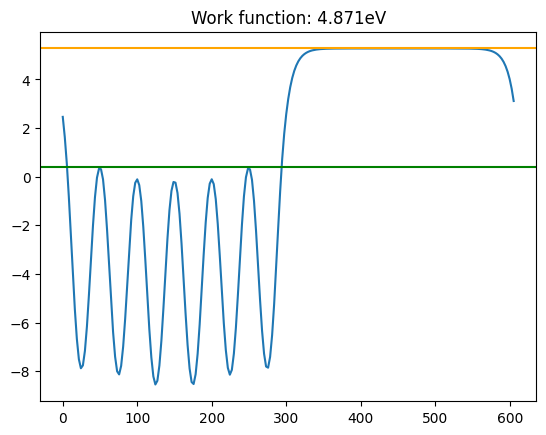

In [21]:
!rm avg.dat
lines="""&inputPP
   outdir='film',
   prefix='RELAX',
   plot_num=11,
   filplot = 'film.pot'
/

&plot
   filepp(1) = 'film.pot'
   iflag=3,
   output_format=5,
   fileout = 'film.xsf',
/
"""
with open("pp_film.in","w") as f:
    f.write(lines)
!/content/q-e/bin/pp.x<pp_film.in
lines="""1
film.pot
1.0
25
3
2.0
"""
with open("average_film.in","w") as f:
    f.write(lines)
!/content/q-e/bin/average.x<average_film.in
import numpy as np
%matplotlib inline
import  matplotlib.pyplot as plt

film_avg=13.6*np.loadtxt('avg.dat')
from jarvis.io.qe.outputs import DataFileSchema

d=DataFileSchema("film/RELAX.save/data-file-schema.xml")
efermi_film = d.efermi
plt.plot(film_avg[:,0],film_avg[:,1])
plt.axhline(y=efermi_film,c='g')
plt.axhline(y=max(film_avg[:,1]),c='orange')
wf=round(max(film_avg[:,1])-efermi_film,3)
plt.title('Work function: '+str(wf)+'eV')
plt.show()


     Program POST-PROC v.7.3.1 starts on  4Oct2024 at  2:15:12 

     This program is part of the open-source Quantum ESPRESSO suite
     for quantum simulation of materials; please cite
         "P. Giannozzi et al., J. Phys.:Condens. Matter 21 395502 (2009);
         "P. Giannozzi et al., J. Phys.:Condens. Matter 29 465901 (2017);
         "P. Giannozzi et al., J. Chem. Phys. 152 154105 (2020);
          URL http://www.quantum-espresso.org", 
     in publications or presentations arising from this work. More details at
     http://www.quantum-espresso.org/quote

     Serial version
     8225 MiB available memory on the printing compute node when the environment starts


     Reading xml data from directory:

     subs/RELAX.save/

     IMPORTANT: XC functional enforced from input :
     Exchange-correlation= PBESOL
                           (   1   4  10   8   0   0   0)
     Any further DFT definition will be discarded
     Please, verify this is what you really want


     G-vect

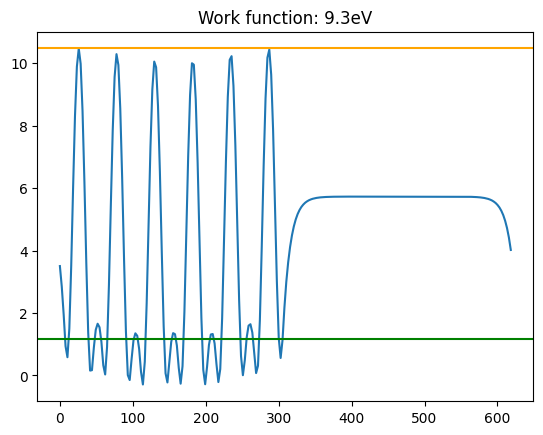

In [23]:
!rm avg.dat
lines="""&inputPP
   outdir='subs',
   prefix='RELAX',
   plot_num=11,
   filplot = 'subs.pot'
/

&plot
   filepp(1) = 'subs.pot'
   iflag=3,
   output_format=5,
   fileout = 'subs.xsf',
/
"""
with open("pp_subs.in","w") as f:
    f.write(lines)
!/content/q-e/bin/pp.x<pp_subs.in
lines="""1
subs.pot
1.0
25
3
2.0
"""
with open("average_subs.in","w") as f:
    f.write(lines)
!/content/q-e/bin/average.x<average_subs.in
import numpy as np
%matplotlib inline
import  matplotlib.pyplot as plt

subs_avg=13.6*np.loadtxt('avg.dat')
from jarvis.io.qe.outputs import DataFileSchema

d=DataFileSchema("subs/RELAX.save/data-file-schema.xml")
efermi_subs = d.efermi
plt.plot(subs_avg[:,0],subs_avg[:,1])
plt.axhline(y=efermi_subs,c='g')
plt.axhline(y=max(subs_avg[:,1]),c='orange')
wf=round(max(subs_avg[:,1])-efermi_subs,3)
plt.title('Work function: '+str(wf)+'eV')
plt.show()


     Program POST-PROC v.7.3.1 starts on  4Oct2024 at  2:18:42 

     This program is part of the open-source Quantum ESPRESSO suite
     for quantum simulation of materials; please cite
         "P. Giannozzi et al., J. Phys.:Condens. Matter 21 395502 (2009);
         "P. Giannozzi et al., J. Phys.:Condens. Matter 29 465901 (2017);
         "P. Giannozzi et al., J. Chem. Phys. 152 154105 (2020);
          URL http://www.quantum-espresso.org", 
     in publications or presentations arising from this work. More details at
     http://www.quantum-espresso.org/quote

     Serial version
     8406 MiB available memory on the printing compute node when the environment starts


     Reading xml data from directory:

     interface/RELAX.save/

     IMPORTANT: XC functional enforced from input :
     Exchange-correlation= PBESOL
                           (   1   4  10   8   0   0   0)
     Any further DFT definition will be discarded
     Please, verify this is what you really want


     G

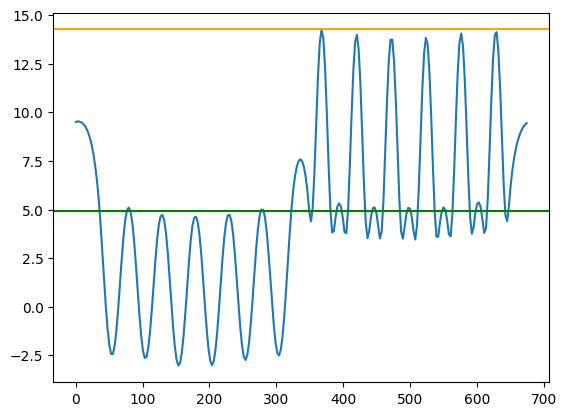

In [25]:
!rm avg.dat
lines="""&inputPP
   outdir='interface',
   prefix='RELAX',
   plot_num=11,
   filplot = 'interface.pot'
/

&plot
   filepp(1) = 'interface.pot'
   iflag=3,
   output_format=5,
   fileout = 'interface.xsf',
/
"""
with open("pp_interface.in","w") as f:
    f.write(lines)
!/content/q-e/bin/pp.x<pp_interface.in
lines="""1
interface.pot
1.0
25
3
2.0
"""
with open("average_interface.in","w") as f:
    f.write(lines)
!/content/q-e/bin/average.x<average_interface.in
import numpy as np
%matplotlib inline
import  matplotlib.pyplot as plt

interface_avg=13.6*np.loadtxt('avg.dat')
from jarvis.io.qe.outputs import DataFileSchema

d=DataFileSchema("interface/RELAX.save/data-file-schema.xml")
efermi_interface = d.efermi
plt.plot(interface_avg[:,0],interface_avg[:,1])
plt.axhline(y=efermi_interface,c='g')
plt.axhline(y=max(interface_avg[:,1]),c='orange')
wf=round(max(interface_avg[:,1])-efermi_interface,3)
# plt.title('Work function: '+str(wf)+'eV')
plt.show()


Number of peaks  11
auto detect left index
left index  2
Initial guess left  47.6042972736
Lleft  -2.8467373740181226e-09


<ipython-input-41-e04b8840a6a0>:40: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  m, c = lstsq(A, y)[0]


Initial guess right  47.604297273599855
Lright  -2.8467363827573946e-09
meanval  [1.1294062196194325, 7.325393517499369] 6.195987297879936 6.232113031620174
deltaE 0.03612573374023764


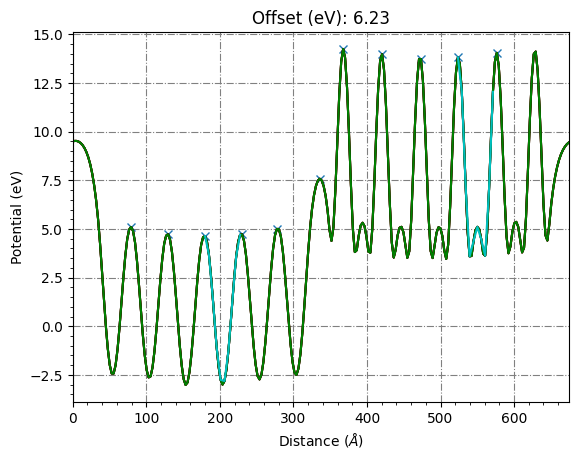

{'phi': 6.232113031620174,
 'polar': False,
 'deltaV': 6.195987297879936,
 'deltaE': 0.03612573374023764,
 'L_guess_peaks_right': 47.604297273599855,
 'L': -2.8467363827573946e-09,
 'left_index': 2}

In [41]:
from scipy.interpolate import CubicSpline
import scipy.integrate as integrate
from numpy import ones, vstack
from numpy.linalg import lstsq
from scipy.signal import find_peaks

step_size = 10

def get_best_L(start_L, end_L, S, x_target):
    """Find best L on grid of 10 points."""
    L = 0
    best = 1000000000.0
    for L_guess in np.arange(
        start_L, end_L + 1e-5, (end_L - start_L) / (step_size + 0.55)
    ):
        current = 0.0
        for xx in x_target:
            current += abs(S(xx) - S(xx + L_guess))
        if current < best:
            best = current
            L = L_guess

    return L

def best_L_recursive(start_L, end_L, S, x_target):
    """Find recursively best L."""
    L_best = 0.0
    L_range = end_L - start_L
    for iter in range(step_size):
        L_best = get_best_L(start_L, end_L, S, x_target)
        L_range = L_range / step_size
        start_L = L_best - L_range
        end_L = L_best + L_range

    return L_best

def get_m_c(x=[], y=[]):
    """Get least sq. fit."""
    A = vstack([x, ones(len(x))]).T
    m, c = lstsq(A, y)[0]
    return m, c

def get_mean_val(x_target, XX, AVG):
    """Get man val."""
    x_target = np.array(x_target)
    XX = np.array(XX)
    AVG = np.array(AVG)
    new_x = XX.searchsorted(x_target)
    new_mean = np.mean(AVG[new_x])
    # print('new_mean',new_mean)
    m, c = get_m_c(x=XX[new_x], y=AVG[new_x])
    # print('new_x',new_x)
    # print('AVG[new_x]',AVG[new_x])
    # print('m,c',m,c)
    return new_mean, m, c

def do_average(L, x, S):
    """Do the actual averaging."""
    AVG = []
    XX = []
    for xx in x:
        if xx - L / 2.0 < x[0]:
            continue
        if xx + L / 2.0 > x[-1]:
            continue
        XX.append(xx)

        # tmp_x = np.arange(xx - L / 2.0, xx + L / 2.0, 0.1)
        # x=np.arange(xx-L/2.0, xx+L/2.0,0.1)
        # tmp_y = S(tmp_x)
        # intg2=np.trapz(tmp_y,tmp_x,tmp_x[1]-tmp_x[0])/L
        intg2 = integrate.quad(S, xx - L / 2.0, xx + L / 2.0)[0] / L
        # print('tmp_x[1]-tmp_x[0]',tmp_x[1]-tmp_x[0])
        # intg2=integrate.simpson(tmp_y,tmp_x,tmp_x[1]-tmp_x[0]) / L
        # print('intg',int)
        AVG.append(intg2)  # integration
    #        print("int ", integrate.quad(S, xx-L/2.0, xx+L/2.0))
    return XX, AVG

def offset(x=[], s=[], width=5, left_index=-1, polar=False,deltaE=0):
    """Get valence band offset."""

    S = CubicSpline(x, s)

    max_peaks, properties = find_peaks(s, prominence=1, width=width)
    max_peaks = max_peaks[:-1]

    print("Number of peaks ", len(max_peaks))
    if left_index == -1:  # automatically pick left_index from max_peaks
        print("auto detect left index")
        if len(max_peaks) <= 8:
            print("WARNING, not many peaks found")
            left_index = 1
        elif len(max_peaks) <= 12:
            left_index = 2
        else:
            left_index = 3
    else:
        print("use input left index")
    print("left index ", left_index)
    right_index = left_index * -1 + 1

    plt.plot(x[max_peaks], s[max_peaks], "x")
    # tmp=int((max_peaks[left_index]-max_peaks[left_index+2]))
    x_target1 = x[
        np.arange(max_peaks[left_index], max_peaks[left_index + 1], 2)
    ]

    # initial guess left
    L_guess_peaks_left = x_target1[-1] - x_target1[0]

    # points in left cell
    # x_target1 = x[ range(50, 100,2) ]
    print("Initial guess left ", L_guess_peaks_left)
    L = best_L_recursive(1.0, L_guess_peaks_left * 1.5, S, x_target1)
    print("Lleft ", L)

    plt.plot(x, s, c="k")
    XX, AVG = do_average(L, x, S)

    meanval1, m1, c1 = get_mean_val(x_target1, XX, AVG)
    if polar:
        plt.plot(XX, np.array(XX) * m1 + c1, c="purple", linestyle="-.")
    # print('x_target1',x_target1)
    # print('XX',XX)
    # print('AVG',AVG)
    plt.plot(XX, AVG, c="r")

    # x_target2 = x[-200:-150]
    # tmp=int((max_peaks[right_index-1]-max_peaks[right_index]))
    x_target2 = x[
        np.arange(max_peaks[right_index - 1], max_peaks[right_index], 2)
    ]
    # x_target2 = x[ range(-100, ,2) ]

    # initial guess right
    L_guess_peaks_right = x_target2[-1] - x_target2[0]
    L = best_L_recursive(1.0, L_guess_peaks_right * 1.5, S, x_target2)
    print("Initial guess right ", L_guess_peaks_right)
    print("Lright ", L)

    plt.plot(x, s, c="k")
    XX, AVG = do_average(L, x, S)
    meanval2, m2, c2 = get_mean_val(x_target2, XX, AVG)
    if polar:
        plt.plot(XX, np.array(XX) * m2 + c2, c="orange", linestyle="-.")

    if polar:
        mid_point = int((len(XX) - 1) / 2)
        polar_del_V = (np.array(XX) * m2 + c2)[mid_point] - (
            np.array(XX) * m1 + c1
        )[mid_point]
        plt.plot(mid_point, -7, "*")
        plt.axvline(x=XX[mid_point], linestyle="-.", c="blue")
        print(
            "polar delV,mid_point",
            polar_del_V,
            mid_point,
            len(XX),
            XX[mid_point],
        )

    plt.plot(XX, AVG, c="g")
    plt.plot(x_target1, S(x_target1), "c")
    plt.plot(x_target2, S(x_target2), "c")
    deltaV = meanval2 - meanval1
    phi = deltaV + deltaE
    if polar:
        phi = polar_del_V + deltaE
        deltaV = polar_del_V
    plt.grid(color="gray", ls="-.")
    plt.minorticks_on()
    plt.ylabel("Potential (eV)")
    plt.xlim(0, max(x))
    plt.xlabel(r"Distance ($\AA$)")
    # plt.plot(x,[meanval1 for i in range(len(x))],linestyle='-.',color='blue')
    # plt.plot(x,[meanval2 for i in range(len(x))],linestyle='-.',color='blue')
    print("meanval ", [meanval1, meanval2], meanval2 - meanval1, phi)
    plt.title("Offset (eV): " + str(round(phi, 2)))
    filename = "offset.png"
    print("deltaE", deltaE)
    plt.show()
    # plt.savefig(filename)
    # plt.close()
    info = {}
    info["phi"] = phi
    info["polar"] = polar
    info["deltaV"] = deltaV
    info["deltaE"] = deltaE
    info["L_guess_peaks_right"] = L_guess_peaks_right
    info["L"] = L
    info["left_index"] = left_index

    return info  # phi
offset(x=interface_avg[:,0],s=interface_avg[:,1],deltaE=delta_E)

Extra blocks

In [5]:
from jarvis.core.atoms import Atoms
from jarvis.io.vasp.inputs import Poscar
from intermat.generate import InterfaceCombi
import numpy as np
film_pos = """MoS2
1.0
1.5939818713880687 -2.7608568870413697 0.0
1.5939818713880687 2.7608568870413697 0.0
0.0 0.0 34.879004
Mo S
1 2
Cartesian
1.59398 -0.9202885072399822 3.7197407130000837
1.59398 0.9202885072399822 2.153121547584768
1.59398 0.9202885072399822 5.286394757415309
"""
subs_pos = """Te2Mo
1.0
1.7811816828576317 -3.08509790977307 0.0
1.7811816828576317 3.08509790977307 0.0
0.0 0.0 35.346645
Te Mo
2 1
Cartesian
1.78118 -1.02836872339998 2.024632306765125
1.78118 -1.02836872339998 5.648699077555013
1.78118 1.0283687233999803 3.8366656921600706
"""

# film_pos = """Si2
# 1.0
# 3.3641499856336465 -2.5027128e-09 1.94229273881412
# 1.121382991333525 3.1717517190189715 1.9422927388141193
# -2.5909987e-09 -1.8321133e-09 3.884586486670313
# Si
# 2
# Cartesian
# 3.92483875 2.77528125 6.7980237500000005
# 0.56069125 0.39646875 0.9711462500000001
# """
# subs_pos = """GaAs
# 1.0
# 3.509895098013499 -6.584084e-10 2.026439508259945
# 1.169965032050413 3.3091606691404545 2.026439508259945
# -1.8622597e-09 -1.3168164e-09 4.052878022970947
# Ga As
# 1 1
# Cartesian
# 0.0 0.0 0.0
# 1.1699675 0.82729 2.02644
# """
# subs_pos="""Ge2
# 1.0
# 3.5261943628070638 1.196611e-10 2.035849771621022
# 1.1753977879818787 3.3245278496612793 2.035849771621022
# -4.62335e-10 -3.269202e-10 4.071698544842951
# Ge
# 2
# Cartesian
# 4.11389125 2.9089637500000003 7.125475
# 0.58769875 0.41556625 1.017925
# """


film = Poscar.from_string(film_pos).atoms
subs = Poscar.from_string(subs_pos).atoms

x = InterfaceCombi(
    film_mats=[film],
    subs_mats=[subs],
    # film_indices=[[1,1,0]],
    # subs_indices=[[1,1,0]],

    film_indices=[[0,0,1]],
    subs_indices=[[0,0,1]],

    disp_intvl=0.0,
    vacuum_interface=2,
    # dataset=None,
    from_conventional_structure_film=False,
    from_conventional_structure_subs=False,
)
wads = x.calculate_wad(method="ewald")
index = np.argmin(wads) # important for disp_intvl not equal zero
combined = Atoms.from_dict(x.generated_interfaces[index]["generated_interface"])
film_interface = Atoms.from_dict(x.generated_interfaces[index]["film_surf"]).center(vacuum=6)
subs_interface = Atoms.from_dict(x.generated_interfaces[index]["subs_surf"]).center(vacuum=6)


Obtaining 3D dataset 76k ...
Reference:https://www.nature.com/articles/s41524-020-00440-1
Other versions:https://doi.org/10.6084/m9.figshare.6815699


100%|██████████| 40.8M/40.8M [00:02<00:00, 15.5MiB/s]


Loading the zipfile...
Loading completed.
len generated 1


100%|██████████| 1/1 [00:00<00:00, 18.44it/s]


In [7]:
from ase.visualize import view
view(combined.ase_converter(),viewer='x3d')

In [8]:
from ase.visualize import view
view(film_interface.ase_converter(),viewer='x3d')

In [9]:
from ase.visualize import view
view(subs_interface.ase_converter(),viewer='x3d')

In [10]:
combined.num_atoms

21

In [11]:
os.chdir('/content')

In [12]:
%%time
from intermat.config import IntermatConfig
from intermat.calculators import Calc
params = IntermatConfig().dict()
qe_cmd = "/content/q-e/bin/pw.x"
params['kp_length'] = 0
params['qe_params']['qe_cmd'] = qe_cmd

method = "qe"
calc = Calc(
    method=method,
    atoms=film_interface,
    extra_params=params,
    jobname="film",
)
out_film= calc.predict()
en = out_film["total_energy"]
print(en)

Please cite for PSPs:
https://doi.org/10.1016/j.commatsci.2013.08.053
Sanitizing Atoms.
cmd /content/q-e/bin/pw.x<arelax.in
HERE1
HERE2 /content/film/RELAX.save/data-file-schema.xml
-2544.1656706607555
CPU times: user 660 ms, sys: 245 ms, total: 905 ms
Wall time: 52.7 s


In [13]:
%%time
from intermat.config import IntermatConfig
from intermat.calculators import Calc
params = IntermatConfig().dict()
qe_cmd = "/content/q-e/bin/pw.x"
params['kp_length'] = 0
params['qe_params']['qe_cmd'] = qe_cmd

method = "qe"
calc = Calc(
    method=method,
    atoms=subs_interface,
    extra_params=params,
    jobname="subs",
)
out_subs= calc.predict()
en = out_subs["total_energy"]
print(en)

Please cite for PSPs:
https://doi.org/10.1016/j.commatsci.2013.08.053
Sanitizing Atoms.
cmd /content/q-e/bin/pw.x<arelax.in
HERE1
HERE2 /content/subs/RELAX.save/data-file-schema.xml
-2607.1447758100026
CPU times: user 151 ms, sys: 119 ms, total: 270 ms
Wall time: 52.4 s


In [14]:
%%time
from intermat.config import IntermatConfig
from intermat.calculators import Calc
params = IntermatConfig().dict()
qe_cmd = "/content/q-e/bin/pw.x"
params['kp_length'] = 0
params['qe_params']['qe_cmd'] = qe_cmd

method = "qe"
calc = Calc(
    method=method,
    atoms=combined,
    extra_params=params,
    jobname="interface",
)
out_int= calc.predict()
en = out_int["total_energy"]
print(en)

Please cite for PSPs:
https://doi.org/10.1016/j.commatsci.2013.08.053
Sanitizing Atoms.
cmd /content/q-e/bin/pw.x<arelax.in
HERE1
HERE2 /content/interface/RELAX.save/data-file-schema.xml
-18050.476716420955
CPU times: user 853 ms, sys: 216 ms, total: 1.07 s
Wall time: 5min 34s


In [15]:
os.chdir('/content')

### Post-processing

In [16]:
lines="""&inputPP
   outdir='film',
   prefix='RELAX',
   plot_num=11,
   filplot = 'film.pot'
/

&plot
   filepp(1) = 'film.pot'
   iflag=3,
   output_format=5,
   fileout = 'film.xsf',
/
"""
with open("pp_film.in","w") as f:
    f.write(lines)
!/content/q-e/bin/pp.x<pp_film.in


     Program POST-PROC v.7.3.1 starts on  3Oct2024 at 22:30:12 

     This program is part of the open-source Quantum ESPRESSO suite
     for quantum simulation of materials; please cite
         "P. Giannozzi et al., J. Phys.:Condens. Matter 21 395502 (2009);
         "P. Giannozzi et al., J. Phys.:Condens. Matter 29 465901 (2017);
         "P. Giannozzi et al., J. Chem. Phys. 152 154105 (2020);
          URL http://www.quantum-espresso.org", 
     in publications or presentations arising from this work. More details at
     http://www.quantum-espresso.org/quote

     Serial version
     6019 MiB available memory on the printing compute node when the environment starts


     Reading xml data from directory:

     film/RELAX.save/

     IMPORTANT: XC functional enforced from input :
     Exchange-correlation= PBESOL
                           (   1   4  10   8   0   0   0)
     Any further DFT definition will be discarded
     Please, verify this is what you really want


     G-vect


     Program AVERAGE v.7.3.1 starts on  3Oct2024 at 22:37: 2 

     This program is part of the open-source Quantum ESPRESSO suite
     for quantum simulation of materials; please cite
         "P. Giannozzi et al., J. Phys.:Condens. Matter 21 395502 (2009);
         "P. Giannozzi et al., J. Phys.:Condens. Matter 29 465901 (2017);
         "P. Giannozzi et al., J. Chem. Phys. 152 154105 (2020);
          URL http://www.quantum-espresso.org", 
     in publications or presentations arising from this work. More details at
     http://www.quantum-espresso.org/quote

     Serial version
     5958 MiB available memory on the printing compute node when the environment starts

     Reading header from file  film.pot
Notice: npt was too small and is set to  144 (number of points in 1D FFT)
     Reading data from file  film.pot
     Output written to file avg.dat

     AVERAGE      :      0.11s CPU      0.11s WALL


   This run was terminated on:  22:37: 2   3Oct2024            

=-------------

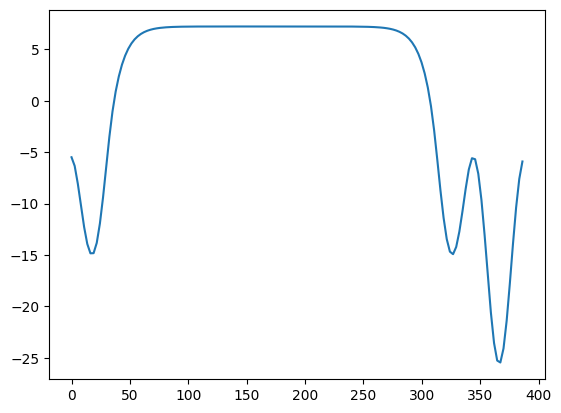

In [33]:
lines="""1
film.pot
1.0
25
3
2.0
"""
with open("average_film.in","w") as f:
    f.write(lines)
!/content/q-e/bin/average.x<average_film.in
import numpy as np
%matplotlib inline
import  matplotlib.pyplot as plt

film_avg=13.6*np.loadtxt('avg.dat')
plt.plot(film_avg[:,0],film_avg[:,1])

In [20]:
lines="""&inputPP
   outdir='interface',
   prefix='RELAX',
   plot_num=11,
   filplot = 'interface.pot'
/

&plot
   filplot(1) = 'interface.pot'
   iflag=3,
   output_format=5
/
"""
with open("pp_interface.in","w") as f:
    f.write(lines)
!/content/q-e/bin/pp.x<pp_interface.in


     Program POST-PROC v.7.3.1 starts on  3Oct2024 at 22:33:31 

     This program is part of the open-source Quantum ESPRESSO suite
     for quantum simulation of materials; please cite
         "P. Giannozzi et al., J. Phys.:Condens. Matter 21 395502 (2009);
         "P. Giannozzi et al., J. Phys.:Condens. Matter 29 465901 (2017);
         "P. Giannozzi et al., J. Chem. Phys. 152 154105 (2020);
          URL http://www.quantum-espresso.org", 
     in publications or presentations arising from this work. More details at
     http://www.quantum-espresso.org/quote

     Serial version
     5976 MiB available memory on the printing compute node when the environment starts


     Reading xml data from directory:

     interface/RELAX.save/

     IMPORTANT: XC functional enforced from input :
     Exchange-correlation= PBESOL
                           (   1   4  10   8   0   0   0)
     Any further DFT definition will be discarded
     Please, verify this is what you really want


     G


     Program AVERAGE v.7.3.1 starts on  3Oct2024 at 22:37:18 

     This program is part of the open-source Quantum ESPRESSO suite
     for quantum simulation of materials; please cite
         "P. Giannozzi et al., J. Phys.:Condens. Matter 21 395502 (2009);
         "P. Giannozzi et al., J. Phys.:Condens. Matter 29 465901 (2017);
         "P. Giannozzi et al., J. Chem. Phys. 152 154105 (2020);
          URL http://www.quantum-espresso.org", 
     in publications or presentations arising from this work. More details at
     http://www.quantum-espresso.org/quote

     Serial version
     5932 MiB available memory on the printing compute node when the environment starts

     Reading header from file  interface.pot
Notice: npt was too small and is set to  128 (number of points in 1D FFT)
     Reading data from file  interface.pot
     Output written to file avg.dat

     AVERAGE      :      0.26s CPU      0.27s WALL


   This run was terminated on:  22:37:18   3Oct2024            

=---

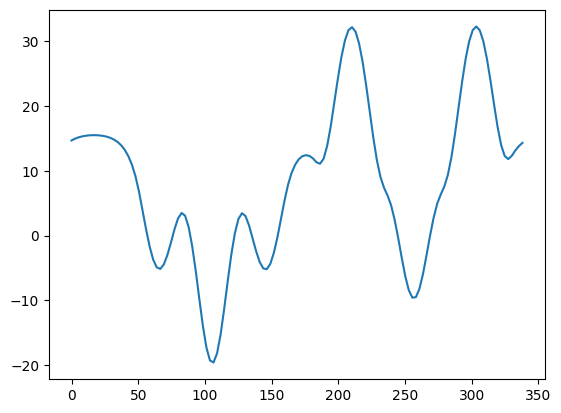

In [34]:
lines="""1
interface.pot
1.0
25
3
2.0
"""
with open("average_interface.in","w") as f:
    f.write(lines)
!/content/q-e/bin/average.x<average_interface.in
import numpy as np
%matplotlib inline
import  matplotlib.pyplot as plt

interface_avg=13.6*np.loadtxt('avg.dat')
plt.plot(interface_avg[:,0],interface_avg[:,1])


In [37]:
lines="""&inputPP
   outdir='subs',
   prefix='RELAX',
   plot_num=11,
   filplot = 'subs.pot'
/

&plot
   filplot(1) = 'subs.pot'
   iflag=3,
   output_format=5,
   e1(1) = 0.0, e1(2) = 0.0, e1(3) = 1.0,
   fileout = 'avg_z_subs.dat',
/
"""
with open("pp_subs.in","w") as f:
    f.write(lines)
!/content/q-e/bin/pp.x<pp_subs.in


     Program POST-PROC v.7.3.1 starts on  3Oct2024 at 22:37:54 

     This program is part of the open-source Quantum ESPRESSO suite
     for quantum simulation of materials; please cite
         "P. Giannozzi et al., J. Phys.:Condens. Matter 21 395502 (2009);
         "P. Giannozzi et al., J. Phys.:Condens. Matter 29 465901 (2017);
         "P. Giannozzi et al., J. Chem. Phys. 152 154105 (2020);
          URL http://www.quantum-espresso.org", 
     in publications or presentations arising from this work. More details at
     http://www.quantum-espresso.org/quote

     Serial version
     7411 MiB available memory on the printing compute node when the environment starts


     Reading xml data from directory:

     subs/RELAX.save/

     IMPORTANT: XC functional enforced from input :
     Exchange-correlation= PBESOL
                           (   1   4  10   8   0   0   0)
     Any further DFT definition will be discarded
     Please, verify this is what you really want


     G-vect


     Program AVERAGE v.7.3.1 starts on  3Oct2024 at 22:37:58 

     This program is part of the open-source Quantum ESPRESSO suite
     for quantum simulation of materials; please cite
         "P. Giannozzi et al., J. Phys.:Condens. Matter 21 395502 (2009);
         "P. Giannozzi et al., J. Phys.:Condens. Matter 29 465901 (2017);
         "P. Giannozzi et al., J. Chem. Phys. 152 154105 (2020);
          URL http://www.quantum-espresso.org", 
     in publications or presentations arising from this work. More details at
     http://www.quantum-espresso.org/quote

     Serial version
     7441 MiB available memory on the printing compute node when the environment starts

     Reading header from file  film.pot
Notice: npt was too small and is set to  144 (number of points in 1D FFT)
     Reading data from file  film.pot
     Output written to file avg.dat

     AVERAGE      :      0.11s CPU      0.11s WALL


   This run was terminated on:  22:37:59   3Oct2024            

=-------------

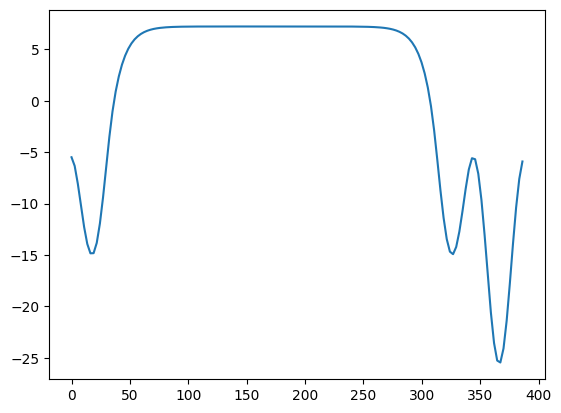

In [38]:
lines="""1
subs.pot
1.0
25
3
2.0
"""
with open("average_subs.in","w") as f:
    f.write(lines)
!/content/q-e/bin/average.x<average_film.in
import numpy as np
%matplotlib inline
import  matplotlib.pyplot as plt

subs_avg=13.6*np.loadtxt('avg.dat')
plt.plot(subs_avg[:,0],subs_avg[:,1])

In [39]:
from jarvis.core.atoms import Atoms
from jarvis.io.vasp.inputs import Poscar
from intermat.generate import InterfaceCombi
import numpy as np


film_pos = """Si2
1.0
3.3641499856336465 -2.5027128e-09 1.94229273881412
1.121382991333525 3.1717517190189715 1.9422927388141193
-2.5909987e-09 -1.8321133e-09 3.884586486670313
Si
2
Cartesian
3.92483875 2.77528125 6.7980237500000005
0.56069125 0.39646875 0.9711462500000001
"""
subs_pos = """GaAs
1.0
3.509895098013499 -6.584084e-10 2.026439508259945
1.169965032050413 3.3091606691404545 2.026439508259945
-1.8622597e-09 -1.3168164e-09 4.052878022970947
Ga As
1 1
Cartesian
0.0 0.0 0.0
1.1699675 0.82729 2.02644
"""



film = Poscar.from_string(film_pos).atoms
subs = Poscar.from_string(subs_pos).atoms

x = InterfaceCombi(
    film_mats=[film],
    subs_mats=[subs],
    film_indices=[[1,1,0]],
    subs_indices=[[1,1,0]],

    disp_intvl=0.1,
    vacuum_interface=2,
    # dataset=None,
    from_conventional_structure_film=True,
    from_conventional_structure_subs=True,
)
wads = x.calculate_wad(method="ewald")
index = np.argmin(wads) # important for disp_intvl not equal zero
combined = Atoms.from_dict(x.generated_interfaces[index]["generated_interface"])
film_interface = Atoms.from_dict(x.generated_interfaces[index]["film_surf"]).center(vacuum=6)
subs_interface = Atoms.from_dict(x.generated_interfaces[index]["subs_surf"]).center(vacuum=6)


Obtaining 3D dataset 76k ...
Reference:https://www.nature.com/articles/s41524-020-00440-1
Other versions:https://doi.org/10.6084/m9.figshare.6815699
Loading the zipfile...
Loading completed.


/usr/local/lib/python3.10/dist-packages/spglib/spglib.py:115: DeprecationWarning: dict interface (SpglibDataset['number']) is deprecated.Use attribute interface ({self.__class__.__name__}.{key}) instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/spglib/spglib.py:115: DeprecationWarning: dict interface (SpglibDataset['international']) is deprecated.Use attribute interface ({self.__class__.__name__}.{key}) instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/intermat/generate.py:52: RuntimeWarning: invalid value encountered in scalar divide
  strain_x = (
/usr/local/lib/python3.10/dist-packages/intermat/generate.py:55: RuntimeWarning: invalid value encountered in scalar divide
  strain_y = (


len generated 100


100%|██████████| 100/100 [00:21<00:00,  4.58it/s]


In [40]:
%%time
from intermat.config import IntermatConfig
from intermat.calculators import Calc
params = IntermatConfig().dict()
qe_cmd = "/content/q-e/bin/pw.x"
params['kp_length'] = 0
params['qe_params']['qe_cmd'] = qe_cmd

method = "qe"
calc = Calc(
    method=method,
    atoms=film_interface,
    extra_params=params,
    jobname="film2",
)
out_film= calc.predict()
en = out_film["total_energy"]
print(en)

Please cite for PSPs:
https://doi.org/10.1016/j.commatsci.2013.08.053
Sanitizing Atoms.
cmd /content/q-e/bin/pw.x<arelax.in
HERE1
HERE2 /content/film2/RELAX.save/data-file-schema.xml
-3106.2733623440085
CPU times: user 1.2 s, sys: 301 ms, total: 1.5 s
Wall time: 7min 3s


In [41]:
%%time
from intermat.config import IntermatConfig
from intermat.calculators import Calc
params = IntermatConfig().dict()
qe_cmd = "/content/q-e/bin/pw.x"
params['kp_length'] = 0
params['qe_params']['qe_cmd'] = qe_cmd

method = "qe"
calc = Calc(
    method=method,
    atoms=subs_interface,
    extra_params=params,
    jobname="subs2",
)
out_subs= calc.predict()
en = out_subs["total_energy"]
print(en)

Please cite for PSPs:
https://doi.org/10.1016/j.commatsci.2013.08.053
Sanitizing Atoms.
cmd /content/q-e/bin/pw.x<arelax.in
HERE1
HERE2 /content/subs2/RELAX.save/data-file-schema.xml
-74279.25289776777
CPU times: user 3.45 s, sys: 708 ms, total: 4.15 s
Wall time: 20min 48s


In [42]:
%%time
from intermat.config import IntermatConfig
from intermat.calculators import Calc
params = IntermatConfig().dict()
qe_cmd = "/content/q-e/bin/pw.x"
params['kp_length'] = 0
params['qe_params']['qe_cmd'] = qe_cmd

method = "qe"
calc = Calc(
    method=method,
    atoms=combined,
    extra_params=params,
    jobname="interface2",
)
out_int= calc.predict()
en = out_int["total_energy"]
print(en)

Please cite for PSPs:
https://doi.org/10.1016/j.commatsci.2013.08.053
Sanitizing Atoms.
cmd /content/q-e/bin/pw.x<arelax.in
HERE1
HERE2 /content/interface2/RELAX.save/data-file-schema.xml
-77386.93864767303
CPU times: user 7.2 s, sys: 1.36 s, total: 8.56 s
Wall time: 45min 11s



     Program POST-PROC v.7.3.1 starts on  4Oct2024 at  0:20: 7 

     This program is part of the open-source Quantum ESPRESSO suite
     for quantum simulation of materials; please cite
         "P. Giannozzi et al., J. Phys.:Condens. Matter 21 395502 (2009);
         "P. Giannozzi et al., J. Phys.:Condens. Matter 29 465901 (2017);
         "P. Giannozzi et al., J. Chem. Phys. 152 154105 (2020);
          URL http://www.quantum-espresso.org", 
     in publications or presentations arising from this work. More details at
     http://www.quantum-espresso.org/quote

     Serial version
     8855 MiB available memory on the printing compute node when the environment starts


     Reading xml data from directory:

     interface2/RELAX.save/

     IMPORTANT: XC functional enforced from input :
     Exchange-correlation= PBESOL
                           (   1   4  10   8   0   0   0)
     Any further DFT definition will be discarded
     Please, verify this is what you really want


     

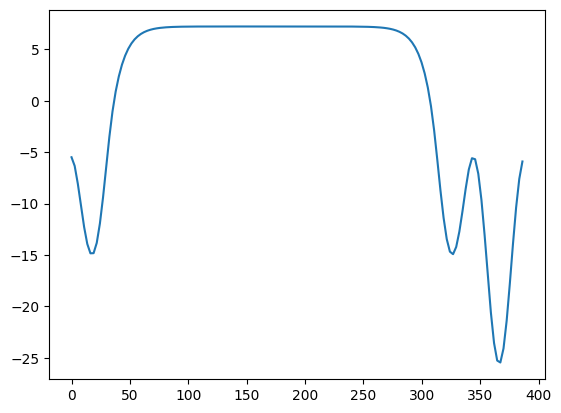

In [52]:
lines="""&inputPP
   outdir='interface2',
   prefix='RELAX',
   plot_num=11,
   filplot = 'interface2.pot'
/

&plot
   filplot(1) = 'interface2.pot'
   iflag=3,
   output_format=5
/
"""
with open("pp_interface2.in","w") as f:
    f.write(lines)
!/content/q-e/bin/pp.x<pp_interface2.in
lines="""1
interface2.pot
1.0
25
3
2.0
"""
with open("average_interface2.in","w") as f:
    f.write(lines)
!/content/q-e/bin/average.x<average_interface2.in
import numpy as np
%matplotlib inline
import  matplotlib.pyplot as plt

interface_avg=13.6*np.loadtxt('avg.dat')
plt.plot(interface_avg2[:,0],interface_avg2[:,1])


In [48]:
import numpy as np
%matplotlib inline
import  matplotlib.pyplot as plt
!rm avg.dat
lines="""&inputPP
   outdir='interface2',
   prefix='RELAX',
   plot_num=11,
   filplot = 'interface2.pot'
/

&plot
   filepp(1) = 'interface2.pot'
   iflag=3,
   output_format=5,
   fileout = 'interface2.xsf',
/
"""
with open("pp_interface2.in","w") as f:
    f.write(lines)
!/content/q-e/bin/pp.x<pp_interface2.in
lines="""1
interface2.pot
1.0
25
3
2.0
"""
with open("average_interface2.in","w") as f:
    f.write(lines)



rm: cannot remove 'avg.dat': No such file or directory

     Program POST-PROC v.7.3.1 starts on  4Oct2024 at  0:16:13 

     This program is part of the open-source Quantum ESPRESSO suite
     for quantum simulation of materials; please cite
         "P. Giannozzi et al., J. Phys.:Condens. Matter 21 395502 (2009);
         "P. Giannozzi et al., J. Phys.:Condens. Matter 29 465901 (2017);
         "P. Giannozzi et al., J. Chem. Phys. 152 154105 (2020);
          URL http://www.quantum-espresso.org", 
     in publications or presentations arising from this work. More details at
     http://www.quantum-espresso.org/quote

     Serial version
     8869 MiB available memory on the printing compute node when the environment starts


     Reading xml data from directory:

     interface2/RELAX.save/

     IMPORTANT: XC functional enforced from input :
     Exchange-correlation= PBESOL
                           (   1   4  10   8   0   0   0)
     Any further DFT definition will be discarded
 

In [51]:
!/content/q-e/bin/average.x<average_interfac2e.in


interface_avg2=13.6*np.loadtxt('avg.dat')
plt.plot(interface_avg2[:,0],interface_avg2[:,1])

/bin/bash: line 1: average_interfac2e.in: No such file or directory


FileNotFoundError: avg.dat not found.

In [50]:
!ls -altr

total 59084
drwxr-xr-x  4 root root     4096 Oct  2 13:25 .config
drwxr-xr-x  1 root root     4096 Oct  2 13:25 sample_data
drwxr-xr-x  1 root root     4096 Oct  3 22:07 ..
drwxr-xr-x 41 root root     4096 Oct  3 22:12 q-e
drwxr-xr-x  3 root root     4096 Oct  3 22:23 film
drwxr-xr-x  3 root root     4096 Oct  3 22:24 subs
drwxr-xr-x  3 root root     4096 Oct  3 22:30 interface
-rw-r--r--  1 root root      181 Oct  3 22:30 pp_film.in
-rw-r--r--  1 root root  3210693 Oct  3 22:30 film.pot
-rw-r--r--  1 root root      200 Oct  3 22:33 pp_interface.in
-rw-r--r--  1 root root  7927582 Oct  3 22:33 interface.pot
-rw-r--r--  1 root root  6801688 Oct  3 22:33 interface.xsf
-rw-r--r--  1 root root       24 Oct  3 22:37 average_film.in
-rw-r--r--  1 root root       29 Oct  3 22:37 average_interface.in
-rw-r--r--  1 root root      229 Oct  3 22:37 pp_subs.in
-rw-r--r--  1 root root  3344440 Oct  3 22:37 subs.pot
-rw-r--r--  1 root root       24 Oct  3 22:37 average_subs.in
drwxr-xr-x  3 root roo

In [31]:
# def read_pot(filename="film.pot"):
#     f=open(filename,"r")
#     lines = f.readlines()
#     f.close()
#     line = lines[1].split()
#     grid=[int(line[0]),int(line[1]),int(line[2])]
#     natoms=int(line[6])
#     species=int(line[7])
#     header=7
#     skip_lines=header+natoms+species
#     chg=[]
#     for line in lines[skip_lines:]:
#         for j in line.split('/n')[0].split():
#           chg.append(float(j))
#     chg=np.array(chg).reshape(grid)
#     return chg
def read_pot(filename="film.pot"):
    f=open(filename,"r")
    lines = f.readlines()
    f.close()
    line = lines[1].split()
    grid=[int(line[0]),int(line[1]),int(line[2])]
    grid_real=[int(line[0])+1,int(line[1])+1,int(line[2])+1]
    print("grid ", grid, " ", grid_real)
    natoms=int(line[6])
    species=int(line[7])
    header=7
    skip_lines=header+natoms+species
    chg=[]
    for line in lines[skip_lines:]:
        for j in line.split('/n')[0].split():
          chg.append(float(j))
          #chg=np.array(chg).reshape(grid)
    print
    print(len(chg))
    print(np.prod(grid))
    print(np.prod(grid_real))
    print
    chg_arr = np.zeros( (grid_real[0], grid_real[1], grid_real[2]))
    c = 0
    for k  in range(grid[2]):
        for j  in range(grid[1]):
            for i  in range(grid[0]):
                #print(i,j,k,c)
                chg_arr[i,j,k] = chg[c]
                c +=1

    for k  in range(grid_real[2]):
        for j  in range(grid_real[1]):
            for i  in range(grid_real[0]):
                chg_arr[i,j,k] = chg_arr[i%grid[0], j%grid[1], k%grid[2]]
    return chg_arr

film_pot = read_pot(filename="film.pot")
subs_pot = read_pot(filename="subs.pot")
interface_pot = read_pot(filename="interface.pot")


grid  [36, 36, 144]   [37, 37, 145]
186624
186624
198505
grid  [36, 36, 150]   [37, 37, 151]
194400
194400
206719
grid  [60, 60, 128]   [61, 61, 129]
460800
460800
480009


WF 2.9783490979548155


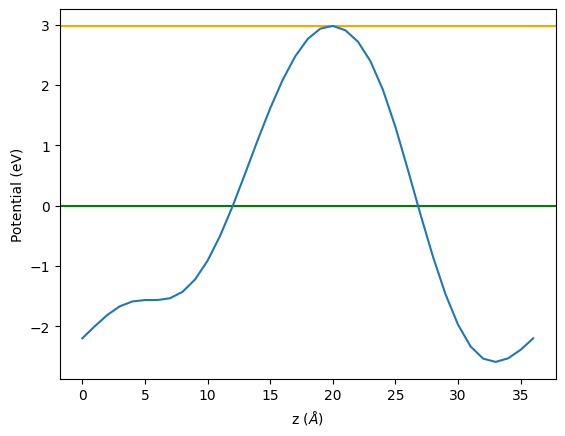

In [41]:

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from jarvis.io.qe.outputs import DataFileSchema
hartree_to_ev = 27.2113839
ry_to_ev = 13.605692
d=DataFileSchema("film/RELAX.save/data-file-schema.xml")
film_efermi = d.efermi
film_mean = ry_to_ev*(np.mean(film_pot,tuple([1,2]))) -film_efermi
print('WF',max(film_mean) )
plt.axhline(y=0,c='g')
plt.axhline(y=np.max(film_mean),c='orange')
plt.xlabel('z ($\AA$)')
plt.ylabel('Potential (eV)')

plt.plot(film_mean)

WF -1.4851404222038465


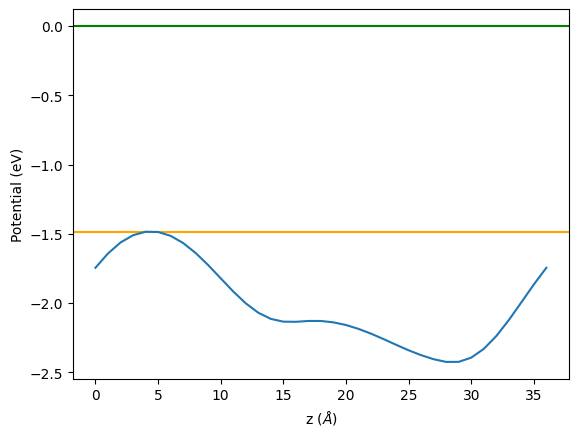

In [33]:

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
d=DataFileSchema("subs/RELAX.save/data-file-schema.xml")
subs_efermi = d.efermi
subs_mean = 1*np.mean(subs_pot,tuple([1,2]))-subs_efermi
print('WF',max(subs_mean) )
plt.axhline(y=0,c='g')
plt.axhline(y=np.max(subs_mean),c='orange')
plt.xlabel('z ($\AA$)')
plt.ylabel('Potential (eV)')
plt.plot(subs_mean)


In [38]:
!ls -altr

total 14192
drwxr-xr-x  4 root root    4096 Oct  2 13:25 .config
drwxr-xr-x  1 root root    4096 Oct  2 13:25 sample_data
drwxr-xr-x  1 root root    4096 Oct  3 17:47 ..
drwxr-xr-x 41 root root    4096 Oct  3 17:53 q-e
drwxr-xr-x  3 root root    4096 Oct  3 18:08 film
drwxr-xr-x  3 root root    4096 Oct  3 18:09 subs
drwxr-xr-x  3 root root    4096 Oct  3 18:14 interface
drwxr-xr-x  1 root root    4096 Oct  3 18:31 .
-rw-r--r--  1 root root     229 Oct  3 18:41 pp_film.in
-rw-r--r--  1 root root 3210693 Oct  3 18:41 film.pot
-rw-r--r--  1 root root     244 Oct  3 18:41 pp_interface.in
-rw-r--r--  1 root root 7927582 Oct  3 18:41 interface.pot
-rw-r--r--  1 root root     229 Oct  3 18:41 pp_subs.in
-rw-r--r--  1 root root 3344440 Oct  3 18:41 subs.pot


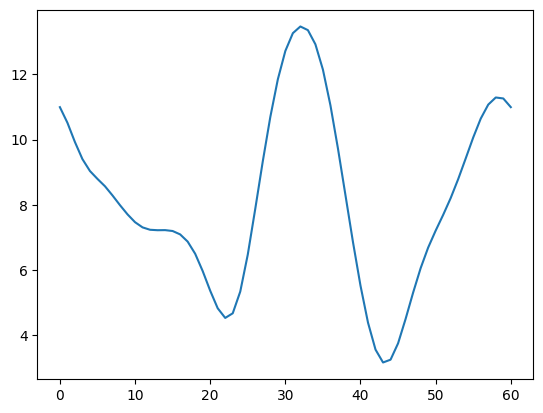

In [34]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
interface_mean = ry_to_ev*np.mean(interface_pot,tuple([1,2]))
x_val = np.arange(len(interface_mean))
plt.plot(interface_mean)


Check polar False
Number of peaks  2
auto detect left index
WARNING, not many peaks found
left index  1


IndexError: index 2 is out of bounds for axis 0 with size 2

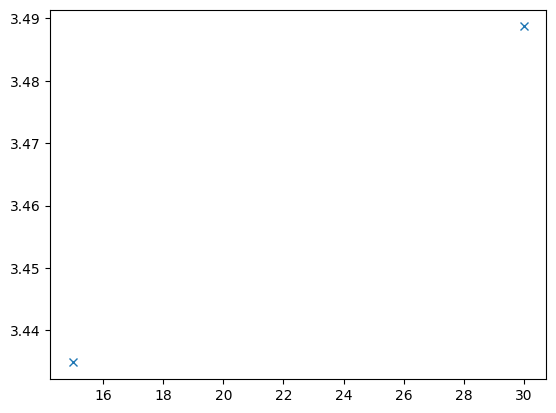

In [ ]:
from intermat.analyze import *
from scipy.interpolate import CubicSpline
from scipy.signal import find_peaks
def offset(fname="", x=[], s=[], width=5, left_index=-1, polar=False):
    """Get valence band offset."""

    if polar is None:
        polar = check_inerface_polar(fname)
    print("Check polar", polar)
    deltaE = 0 #delta_E(fname)
    S = CubicSpline(x, s)

    max_peaks, properties = find_peaks(s, prominence=1, width=width)
    max_peaks = max_peaks[:-1]

    print("Number of peaks ", len(max_peaks))
    if left_index == -1:  # automatically pick left_index from max_peaks
        print("auto detect left index")
        if len(max_peaks) <= 8:
            print("WARNING, not many peaks found")
            left_index = 1
        elif len(max_peaks) <= 12:
            left_index = 2
        else:
            left_index = 3
    else:
        print("use input left index")
    print("left index ", left_index)
    right_index = left_index * -1 + 1

    plt.plot(x[max_peaks], s[max_peaks], "x")
    # tmp=int((max_peaks[left_index]-max_peaks[left_index+2]))
    x_target1 = x[
        np.arange(max_peaks[left_index], max_peaks[left_index + 1], 2)
    ]

    # initial guess left
    L_guess_peaks_left = x_target1[-1] - x_target1[0]

    # points in left cell
    # x_target1 = x[ range(50, 100,2) ]
    print("Initial guess left ", L_guess_peaks_left)
    L = best_L_recursive(1.0, L_guess_peaks_left * 1.5, S, x_target1)
    print("Lleft ", L)

    plt.plot(x, s, c="k")
    XX, AVG = do_average(L, x, S)

    meanval1, m1, c1 = get_mean_val(x_target1, XX, AVG)
    if polar:
        plt.plot(XX, np.array(XX) * m1 + c1, c="purple", linestyle="-.")
    # print('x_target1',x_target1)
    # print('XX',XX)
    # print('AVG',AVG)
    plt.plot(XX, AVG, c="r")

    # x_target2 = x[-200:-150]
    # tmp=int((max_peaks[right_index-1]-max_peaks[right_index]))
    x_target2 = x[
        np.arange(max_peaks[right_index - 1], max_peaks[right_index], 2)
    ]
    # x_target2 = x[ range(-100, ,2) ]

    # initial guess right
    L_guess_peaks_right = x_target2[-1] - x_target2[0]
    L = best_L_recursive(1.0, L_guess_peaks_right * 1.5, S, x_target2)
    print("Initial guess right ", L_guess_peaks_right)
    print("Lright ", L)

    plt.plot(x, s, c="k")
    XX, AVG = do_average(L, x, S)
    meanval2, m2, c2 = get_mean_val(x_target2, XX, AVG)
    if polar:
        plt.plot(XX, np.array(XX) * m2 + c2, c="orange", linestyle="-.")

    if polar:
        mid_point = int((len(XX) - 1) / 2)
        polar_del_V = (np.array(XX) * m2 + c2)[mid_point] - (
            np.array(XX) * m1 + c1
        )[mid_point]
        plt.plot(mid_point, -7, "*")
        plt.axvline(x=XX[mid_point], linestyle="-.", c="blue")
        print(
            "polar delV,mid_point",
            polar_del_V,
            mid_point,
            len(XX),
            XX[mid_point],
        )

    plt.plot(XX, AVG, c="g")
    plt.plot(x_target1, S(x_target1), "c")
    plt.plot(x_target2, S(x_target2), "c")
    deltaV = meanval2 - meanval1
    phi = deltaV + deltaE
    if polar:
        phi = polar_del_V + deltaE
        deltaV = polar_del_V
    plt.grid(color="gray", ls="-.")
    plt.minorticks_on()
    plt.ylabel("Potential (eV)")
    plt.xlim(0, max(x))
    plt.xlabel(r"Distance ($\AA$)")
    # plt.plot(x,[meanval1 for i in range(len(x))],linestyle='-.',color='blue')
    # plt.plot(x,[meanval2 for i in range(len(x))],linestyle='-.',color='blue')
    print("meanval ", [meanval1, meanval2], meanval2 - meanval1, phi)
    plt.title("Offset (eV): " + str(round(phi, 2)))
    filename = "offset_max-" + fname.split("/")[0] + ".png"
    print("deltaE", deltaE)
    # plt.show()
    plt.savefig(filename)
    plt.close()
    info = {}
    info["phi"] = phi
    info["polar"] = polar
    info["deltaV"] = deltaV
    info["deltaE"] = deltaE
    info["L_guess_peaks_right"] = L_guess_peaks_right
    info["L"] = L
    info["left_index"] = left_index

    return info  # phi


offset(x=x_val,s=interface_mean,)

In [ ]:
from jarvis.io.qe.outputs import DataFileSchema
d=DataFileSchema("film/RELAX.save/data-file-schema.xml")
d.data['qes:espresso']['output']['basis_set']

In [ ]:
import pprint
nr1=int(d.data['qes:espresso']['output']['basis_set']['fft_grid']['@nr1'])
nr2=int(d.data['qes:espresso']['output']['basis_set']['fft_grid']['@nr2'])
nr3=int(d.data['qes:espresso']['output']['basis_set']['fft_grid']['@nr3'])

In [ ]:
d.data['qes:espresso']['output']['basis_set']

{'gamma_only': 'false',
 'ecutwfc': '2.250000000000000E+001',
 'ecutrho': '1.250000000000000E+002',
 'fft_grid': {'@nr1': '36', '@nr2': '36', '@nr3': '144'},
 'fft_smooth': {'@nr1': '27', '@nr2': '27', '@nr3': '125'},
 'fft_box': {'@nr1': '36', '@nr2': '36', '@nr3': '144'},
 'ngm': '59987',
 'ngms': '36549',
 'npwx': '4585',
 'reciprocal_lattice': {'b1': '1.000000000000000E+000  5.773502691896258E-001 -0.000000000000000E+000',
  'b2': '0.000000000000000E+000  1.154700538379252E+000  0.000000000000000E+000',
  'b3': '0.000000000000000E+000 -0.000000000000000E+000  2.106593052536925E-001'}}

In [ ]:
59987/36

1666.3055555555557

In [ ]:
nr1,nr2,nr3

(36, 36, 144)

In [ ]:
data.shape

(209969,)

In [ ]:
nr1*nr2*nr3

186624

In [ ]:
839876/186624

4.500364368998628

In [ ]:
d.data['qes:espresso']['output']['basis_set']

{'gamma_only': 'false',
 'ecutwfc': '2.250000000000000E+001',
 'ecutrho': '1.250000000000000E+002',
 'fft_grid': {'@nr1': '36', '@nr2': '36', '@nr3': '144'},
 'fft_smooth': {'@nr1': '27', '@nr2': '27', '@nr3': '125'},
 'fft_box': {'@nr1': '36', '@nr2': '36', '@nr3': '144'},
 'ngm': '59987',
 'ngms': '36549',
 'npwx': '4585',
 'reciprocal_lattice': {'b1': '1.000000000000000E+000  5.773502691896258E-001 -0.000000000000000E+000',
  'b2': '0.000000000000000E+000  1.154700538379252E+000  0.000000000000000E+000',
  'b3': '0.000000000000000E+000 -0.000000000000000E+000  2.106593052536925E-001'}}